# Processing & Analysis of Biotek Plate Reader Records

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [168]:
import sys
sys.path.insert(0, '../../../../')
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import string
import mwc.bayes
import mwc.stats
import mwc.viz
import mwc.fitderiv
colors = mwc.viz.personal_style()
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [172]:
# Load the data. 
data = pd.read_csv('../../../../data/20190121_37C_glucose_O2_growth_plate.csv')

# Prune the nans
data.dropna(inplace=True)

# Conver the time to minutes
time = pd.DatetimeIndex(data['Time'])
time_min = time.hour * 60 + time.minute + time.second/60
data['Time'] = time_min

# Rename columns for simplicity
data.rename(columns={'Time':'time_min', 'Ti OD600:600':'temp_C'}, inplace=True)

# Melt to longform tidy
data = data.melt(id_vars=['time_min', 'temp_C'])

# Rename variable and value vars.
data.rename(columns={'variable':'well_id', 'value':'od_600nm'}, inplace=True)

# Rename well id to well number. 
alpha_map = {alpha:no for alpha, no in zip(string.ascii_uppercase, np.arange(0, 27, 1) * 12)}
alphanumeric_map = {f'{a}{n}':alpha_map[a] + n for n in np.arange(1, 13, 1) for a in string.ascii_uppercase}

# Rename well ids to numeral.
data['well_id'] = [alphanumeric_map[a] for a in data['well_id'].values]


# Include strain IDs.
strain_wells = {alphanumeric_map[f'{row}{col}']:'dilution' for row in ['C', 'D', 'E', 'F'] for col in np.arange(3, 11, 1)}
for well in data['well_id'].unique():
    if well in strain_wells.keys():
        data.loc[data['well_id']==well, 'strain'] = strain_wells[well]
    else:
        data.loc[data['well_id']==well, 'strain'] = 'blank'
        
# Insert identifier information. 
data['date'] = 20190122
data['carbon'] = 'glucose'
data['run_number'] = 1


# Save it to the output file
data.to_csv('output/20190121_r1_37C_glucose_O2_growth_plate.csv', index=False)

## Analysis 

In [173]:
# Generate a dictionary of the mean blank at each time point. 
blank_vals = {t:val['od_600nm'].mean() for t, val in data[data['strain']=='blank'].groupby(['time_min'])}
for k, v in blank_vals.items():
    data.loc[data['time_min']==k, 'blank_val'] = v
data['od_sub'] = data['od_600nm'] - data['blank_val']


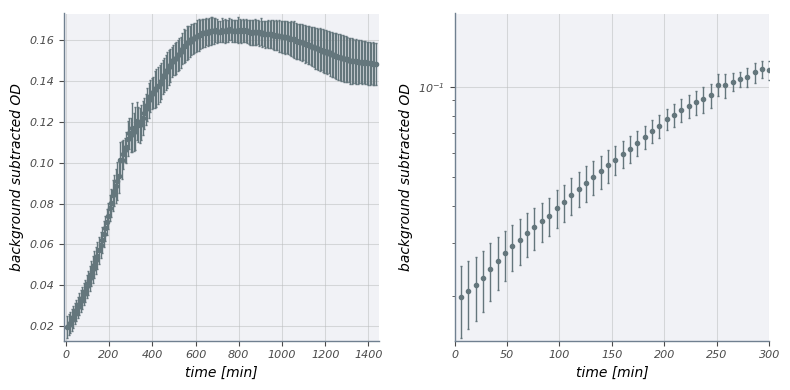

In [174]:
# Plot the growth data. 
grouped = data[data['strain']=='dilution'].groupby(['time_min']).agg(('mean', 'std')).reset_index()
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i in range(2):
    ax[i].set_xlabel('time [min]', fontsize=10)
    ax[i].set_ylabel('background subtracted OD', fontsize=10)

ax[1].set_yscale('log')
ax[1].set_xlim([0, 300])
ax[0].errorbar(grouped['time_min'], grouped['od_sub']['mean'], grouped['od_sub']['std'], linestyle='none',
           lw=1, capsize=1, fmt='.')
ax[1].errorbar(grouped['time_min'], grouped['od_sub']['mean'], grouped['od_sub']['std'], linestyle='none',
           lw=1, capsize=1, fmt='.')
plt.tight_layout()

 Using the data between 100 and 400 min, determine the exponential growth rate

Text(0, 0.5, 'background subtracted absorbance')

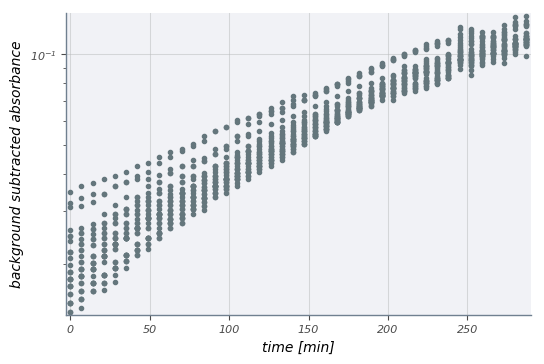

In [175]:
# Restrict to the desired range
restricted = data[(data['strain']=='dilution') & (data['time_min'] >= 0) & (data['time_min'] <= 300)].copy()

# Correct the time
restricted['time_min'] -= restricted['time_min'].min()

# Plot all of the data
fig, ax = plt.subplots(1, 1)
ax.semilogy(restricted['time_min'], restricted['od_sub'], '.')
ax.set_xlabel('time [min]', fontsize=10)
ax.set_ylabel('background subtracted absorbance', fontsize=10)

##  Using Gaussian Processes to Infer Growth Rates

Using the package [`fitderiv`](http://swainlab.bio.ed.ac.uk/software/fitderiv/) from Peter Swain's lab, we can perform non-parametric inference of the time-dependent growth rates of these data

In [ ]:
# Define the bounds. 
bounds = {0: [-1, 5], 1:[-5, 2], 2:[-7, 1]}

# Run the GP
dil_strain = data[data['strain']=='dilution']
gp = mwc.fitderiv.fitderiv(dil_strain['time_min'].values, dil_strain['od_sub'].values)

Taking natural logarithm of the data.
Fitting measurement errors.
Using a squared exponential Gaussian process.
hparam[0] determines the amplitude of variation
hparam[1] determines the flexibility
hparam[2] determines the variance of the measurement error


In [ ]:
dil_strain